#### Import libraries 

In [ ]:
#!pip install bs4
#from bs4 import BeautifulSoup
#!conda install -c conda-forge geopy --yes 
# tranforming json file into a pandas dataframe library
#from pandas.io.json import json_normalize
!conda install -c conda-forge folium=0.10.0 --yes
!pip install lxml
import csv
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import folium # plotting library
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# clustering using scikit-learn
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

**Definition of _FOURSQUARE_ Credentials and Version:**

In [2]:
# The code was removed by Watson Studio for sharing.

**Definition of a function to make search with _FOURSQUARE_ (get a list of venues near interested location, matching a search term):**

In [3]:
def searchForVenues(search_query, names, latitudes, longitudes, radius=3500, LIMIT = 50):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)    
        # Send the GET Request and examine the results
        results = requests.get(url).json()['response']['venues']        
        # return only relevant information for each nearby venue
        venues_list.append([(name, v['id'], v['name'], v['location']['lat'], v['location']['lng'], v['categories']) for v in results])  
        
    f_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    f_venues.columns = ['Neighborhood', 'id', 'Venue', 'Latitude', 'Longitude', 'Category']
    
    for vin in f_venues.index :
        if len(f_venues.loc[vin,'Category']) == 0:
            f_venues.loc[vin,'Category'] = None
        else:
            f_venues.loc[vin,'Category'] = f_venues.loc[vin,'Category'][0]['name']
    
    return(f_venues)

**Definition of a function to explore with _FOURSQUARE_ (get a list of recommended venues near interested location ):**

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['icon']['prefix']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro Station Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                    'Venue icon']
    
    return(nearby_venues)

### The geograpical coordinate of Neighborhoods of MINSK (BELARUS) 

In [5]:
minsk_NGC = pd.read_csv('https://raw.githubusercontent.com/Siarhei-Fialka/Coursera_IBM-Data-Science_Capstone-Project/master/data/Minsk_Neighborhood-location.csv')
minsk_NGC

,Neighborhood,Latitude,Longitude
0,Zavodski raion,53.845710,27.706466
1,Leninski raion,53.864981,27.589991
2,Maskouski raion,53.871098,27.489137
3,Kastrychnitski raion,53.863998,27.536764
4,Partyzanski raion,53.896924,27.661526
5,Pershamayski raion,53.933079,27.666132
6,Savetski raion,53.938209,27.585446
7,Frunzenski raion,53.901750,27.462898
8,Tsentralny raion,53.934580,27.506747
9,Minsk,53.902334,27.561879


### Foursquare location data for Minsk Metro Stations 

**Run the "Search_for_Venues" function on each neighborhood with query - "Metro station":**

In [123]:
minsk_venues = searchForVenues('Станция метро',
                                names=minsk_NGC['Neighborhood'], latitudes=minsk_NGC['Latitude'], longitudes=minsk_NGC['Longitude'])

print('The dataframe has {} rows, where {} rows are unique.'.format(
    minsk_venues.shape[0],len(minsk_venues['Venue'].unique())
    ))
minsk_venues.head()

The dataframe has 367 rows, where 203 rows are unique.


,Neighborhood,id,Venue,Latitude,Longitude,Category
0,Zavodski raion,4de88500ae60293318f2abcc,Станция метро «Могилёвская»,53.861816,27.674346,Metro Station
1,Zavodski raion,4fb2cd9be5e85aadec3ad9e4,Остановка «Станция метро “Могилёвская”»,53.862005,27.675066,Bus Stop
2,Zavodski raion,5dc87a11f983030008e7f81f,Станция Мирная,53.861374,27.709806,Town
3,Zavodski raion,5dc87ae9daa9280008391085,Станция Зарядная,53.855103,27.706760,Town
4,Zavodski raion,5dc87a8682b9e90007f9419d,Станция Солнечная,53.857490,27.708397,Town


**Pre-processing data:**

In [124]:
minsk_venues_filtered = minsk_venues.copy()

# dealing with duplicates and missing values
minsk_venues_filtered.drop_duplicates(subset = 'id', keep = 'first',inplace = True)
minsk_venues_filtered.dropna(inplace = True)

# data cleaning
minsk_metro_stations = minsk_venues_filtered[minsk_venues_filtered['Category'] == "Metro Station"] # filter by category
for stn in ["Станция метро «Площадь Франтишка Богушевича»","Станция метро «Вокзальная»","Станция метро «Ковальская слобода»","Метро",
            "станция метро кавецкой","Станция «Институт Культуры»",'Станция метро "Юбилейная площадь"','Станция метро «Октябрьская» (Станцыя метро «Кастрычніцкая»)'] :
    minsk_metro_stations = minsk_metro_stations[minsk_metro_stations['Venue'] != stn].reset_index(drop=True) # drop incorrect results

# data formatting
for ii,ind in zip(minsk_metro_stations.index, minsk_metro_stations['Venue']) :
    minsk_metro_stations.loc[ii,'Venue'] = ind[ind.find('«')+1:ind.find('»')]
minsk_metro_stations.rename(columns={'Venue':'Metro Station Name _ RUS'},inplace = True) # rename column
    
minsk_metro_stations.drop(columns = ['Neighborhood','id','Category'], inplace = True) # drop uninteresting columns

# translate RU names to ENG names
RU_to_ENG_mms = pd.read_csv('https://raw.githubusercontent.com/Siarhei-Fialka/Coursera_IBM-Data-Science_Capstone-Project/master/data/minsk-metro-stations.csv')
minsk_metro_stations = RU_to_ENG_mms.join(minsk_metro_stations.set_index('Metro Station Name _ RUS'), on = 'Metro Station Name _ RUS')
minsk_metro_stations.drop('Metro Station Name _ RUS',axis=1,inplace = True)

print('The dataframe has {} rows.'.format(minsk_metro_stations.shape[0]))
minsk_metro_stations.head()

The dataframe has 28 rows.


,Metro Station Name,Latitude,Longitude
0,Mahilyowskaya,53.861816,27.674346
1,Ploshcha Lyenina,53.892142,27.548887
2,Pralyetarskaya,53.889670,27.585794
3,Traktarny zavod,53.889343,27.615252
4,Pyershamayskaya,53.893697,27.570153


### Explore area around MINSK Metro Stations (radius 500m)

**Run the "getNearbyVenues" function on each Metro station:**

In [140]:
minsk_venues = getNearbyVenues(names = minsk_metro_stations['Metro Station Name'], latitudes = minsk_metro_stations['Latitude'], longitudes = minsk_metro_stations['Longitude'], 
                               radius = 500
                                )

print('The dataframe has {} rows.'.format(minsk_venues.shape[0]))
minsk_venues.head()

The dataframe has 788 rows.


,Metro Station Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue icon
0,Mahilyowskaya,53.861816,27.674346,ТЦ «МОМО»,53.860728,27.674675,Shopping Mall,https://ss3.4sqi.net/img/categories_v2/shops/m...
1,Mahilyowskaya,53.861816,27.674346,McDonald's,53.859574,27.675019,Fast Food Restaurant,https://ss3.4sqi.net/img/categories_v2/food/fa...
2,Mahilyowskaya,53.861816,27.674346,KFC Momo,53.859200,27.674300,Fast Food Restaurant,https://ss3.4sqi.net/img/categories_v2/food/fa...
3,Mahilyowskaya,53.861816,27.674346,Фудкорт,53.859938,27.674660,Food Court,https://ss3.4sqi.net/img/categories_v2/shops/f...
4,Mahilyowskaya,53.861816,27.674346,Кафе «Papa Taco (Папа Тако)»,53.859578,27.675022,Mexican Restaurant,https://ss3.4sqi.net/img/categories_v2/food/me...


In [ ]:
len(minsk_venues['Venue Category'].unique())

**Add General Categories:**

In [126]:
minsk_venues_GC = minsk_venues.copy()

# get General Category of each venue from 'Venue icon' attribute
for ind in minsk_venues.index :
    minsk_venues_GC.loc[ind,'Venue icon'] = minsk_venues_GC.loc[ind,'Venue icon'][39:]
    minsk_venues_GC.loc[ind,'Venue icon'] = minsk_venues_GC.loc[ind,'Venue icon'][:minsk_venues_GC.loc[ind,'Venue icon'].find('/')]
minsk_venues_GC.rename(columns = {'Venue icon':'General Category'},inplace = True)

print('Unique General Categories in the dataframe: \n {} .'.format(minsk_venues_GC['General Category'].unique()))
minsk_venues_GC.head()

Unique General Categories in the dataframe: 
 ['shops' 'food' 'arts_entertainment' 'travel' 'parks_outdoors' 'building'
 'nightlife' 'education'] .


,Metro Station Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,Mahilyowskaya,53.861816,27.674346,ТЦ «МОМО»,53.860728,27.674675,Shopping Mall,shops
1,Mahilyowskaya,53.861816,27.674346,McDonald's,53.859574,27.675019,Fast Food Restaurant,food
2,Mahilyowskaya,53.861816,27.674346,KFC Momo,53.859200,27.674300,Fast Food Restaurant,food
3,Mahilyowskaya,53.861816,27.674346,Фудкорт,53.859938,27.674660,Food Court,shops
4,Mahilyowskaya,53.861816,27.674346,Кафе «Papa Taco (Папа Тако)»,53.859578,27.675022,Mexican Restaurant,food


**Apply descriptive statistics:**

In [127]:
# remove rows with uninteresting General Category
minsk_venues_GC = minsk_venues_GC[minsk_venues_GC['General Category'] != 'education']
minsk_venues_GC = minsk_venues_GC[minsk_venues_GC['General Category'] != 'building'] # exclude, because it mostly contains gym 
minsk_venues_GC = minsk_venues_GC[minsk_venues_GC['General Category'] != 'travel'] # exclude, because it mostly contains transport infrastructure and hotels  

# group Venue by Metro Station Name and General Category
minsk_venues_GCGr = minsk_venues_GC[['Metro Station Name','Venue','General Category']].groupby(['Metro Station Name','General Category']).count()

# create new dataframe
minsk_venues_byGC = pd.DataFrame()
minsk_venues_byGC.index.set_names('Metro Station Name', inplace = True)

# make columns by General Categories
generalCategoryList = minsk_venues_GC['General Category'].unique() # General Category List
for gcl in generalCategoryList : 
    for msn in minsk_metro_stations['Metro Station Name'] :
        try:
            minsk_venues_byGC.loc[msn,gcl] = minsk_venues_GCGr.loc[(msn,gcl),'Venue']
        except:
            minsk_venues_byGC.loc[msn,gcl] = 0

# add Total column
minsk_venues_GCT = minsk_venues_GC.groupby('Metro Station Name')['Venue'].count()
minsk_venues_byGC = minsk_venues_byGC.join(minsk_venues_GCT, on = 'Metro Station Name')
minsk_venues_byGC.rename(columns = {'Venue':'Total'},inplace = True)

minsk_venues_byGC.head()

,shops,food,arts_entertainment,parks_outdoors,nightlife,Total
Metro Station Name,,,,,,
Mahilyowskaya,8.0,8.0,3.0,1.0,0.0,20
Ploshcha Lyenina,36.0,16.0,2.0,3.0,1.0,58
Pralyetarskaya,10.0,2.0,2.0,2.0,0.0,16
Traktarny zavod,0.0,1.0,1.0,1.0,0.0,3
Pyershamayskaya,5.0,13.0,6.0,3.0,5.0,32


## Visualization of obtained data

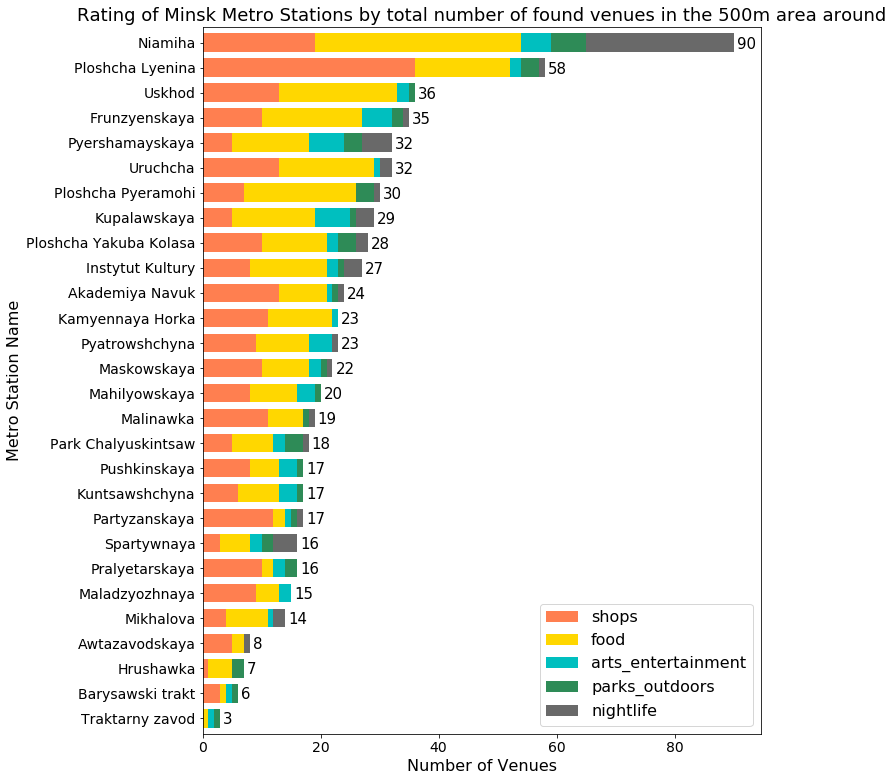

In [128]:
minsk_venues_sorted = minsk_venues_byGC.sort_values(by = 'Total', ascending=True)

minsk_venues_sorted.drop('Total',axis=1).plot(kind='barh', figsize=(10, 13),stacked=True, color = ['coral','gold','c','seagreen','dimgrey'],width=0.75)
plt.xlabel('Number of Venues', size = 16)
plt.ylabel('Metro Station Name', size = 16)
plt.title('Rating of Minsk Metro Stations by total number of found venues in the 500m area around', fontdict = {'fontsize': 18})
plt.tick_params(labelsize = 14)

# annotate value labels to each country
for index, value in enumerate(minsk_venues_sorted['Total']): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar
    plt.annotate(label, xy=(value + 0.5, index - 0.25 ), color='k', ha='left', size=15)
plt.legend(fontsize = 16)
plt.show()

## Clustering of the Metro Stations based on venues around

**Normalization:**

In [129]:
Clus_dataSet = minsk_venues_sorted
Clus_dataSet['Total'] = Clus_dataSet['Total'] + Clus_dataSet['arts_entertainment']*2 + Clus_dataSet['parks_outdoors']*4 # add weight to 'arts_entertainment' and 'parks_outdoors'
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

**Search for the best number of clusters for K-Means clustering:**

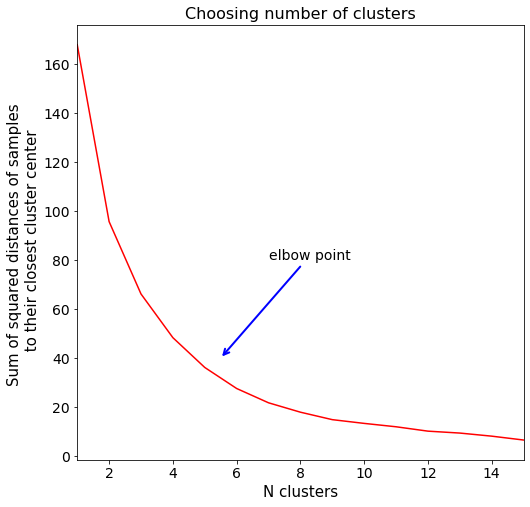

In [130]:
er = pd.DataFrame(columns=['inertia_'])
er.index.set_names('n_clusters', inplace = True)
for kk in np.arange(1,16) :
    db = KMeans(init = "k-means++", n_clusters=kk, n_init = 20, random_state = 0).fit(Clus_dataSet)
    er.loc[kk,'inertia_'] = db.inertia_
er.plot(figsize=(8, 8),legend=None,color='r')
plt.ylabel('Sum of squared distances of samples \n to their closest cluster center',size = 15)
plt.xlabel('N clusters',size = 15)
plt.title('Choosing number of clusters',size = 16)
plt.tick_params(labelsize = 14)
# Annotate arrow
plt.annotate('elbow point',                      # s: str. will leave it blank for no text
             size = 14,
             xy=(5.5, 40),             # place head of the arrow at point 
             xytext=(7, 80),         # place base of the arrow at point 
             xycoords='data',         # will use the coordinate system of the object being annotated 
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2)
            )

plt.show()

**Apply K-Means clustering:**

In [131]:
kclusters = 5

km = KMeans(init = "k-means++", n_clusters=kclusters, n_init = 20, random_state = 0).fit(Clus_dataSet)

minsk_venues_cl = minsk_venues_sorted.copy()
minsk_venues_cl["Cluster"] = km.labels_

minsk_venues_cl = minsk_metro_stations.join(minsk_venues_cl, on = 'Metro Station Name')
minsk_venues_cl.head()

,Metro Station Name,Latitude,Longitude,shops,food,arts_entertainment,parks_outdoors,nightlife,Total,Cluster
0,Mahilyowskaya,53.861816,27.674346,8.0,8.0,3.0,1.0,0.0,30.0,4
1,Ploshcha Lyenina,53.892142,27.548887,36.0,16.0,2.0,3.0,1.0,74.0,3
2,Pralyetarskaya,53.889670,27.585794,10.0,2.0,2.0,2.0,0.0,28.0,4
3,Traktarny zavod,53.889343,27.615252,0.0,1.0,1.0,1.0,0.0,9.0,0
4,Pyershamayskaya,53.893697,27.570153,5.0,13.0,6.0,3.0,5.0,56.0,2


## Visualization

In [132]:
address = 'Minsk, Belarus' 
geolocator = Nominatim(user_agent="msk_explorer")
location_M = geolocator.geocode(address)

# create map and display it
map_Minsk = folium.Map(location=[location_M.latitude, location_M.longitude],tiles='Stamen Terrain', zoom_start=12)

# add Neighborhood division to map
misnk_boredrs_json = 'https://raw.githubusercontent.com/Siarhei-Fialka/Coursera_IBM-Data-Science_Capstone-Project/master/data/minsk_border_.geojson'
map_Minsk.choropleth(
    geo_data = misnk_boredrs_json,
    line_color = 'black',
    fill_color='white',
    fill_opacity = 0.2, 
    line_opacity = 0.4,
    line_weight = 3,
    legend_name='Crime Rate in San Francisco'
)

# add markers with Neighborhood name to map
for lat, lng, neighborhood in zip(minsk_NGC['Latitude'], minsk_NGC['Longitude'], minsk_NGC['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.4,
        opacity = 0.4,
        parse_html=False).add_to(map_Minsk)

    
# set color scheme for the clusters
rainbow = ['blue','gold','red','green','orange']

# add markers bуhind metro sign
for lat, lng, msn, cluster in zip(minsk_venues_cl['Latitude'], minsk_venues_cl['Longitude'], minsk_venues_cl['Metro Station Name'], minsk_venues_cl['Cluster']):
    label = folium.Popup(str(msn) + ' : Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.4,
        opacity = 0.4,
        parse_html=False).add_to(map_Minsk)

metro_logo_url = 'https://raw.githubusercontent.com/Siarhei-Fialka/Coursera_IBM-Data-Science_Capstone-Project/master/data/minsk_metro_logo.png'   
for lat, lng in zip(minsk_metro_stations['Latitude'], minsk_metro_stations['Longitude']):
    folium.features.Marker(
        [lat, lng],
        icon=folium.CustomIcon(metro_logo_url, icon_size=(24, 12))
    ).add_to(map_Minsk)    
    
map_Minsk

In [119]:
minsk_venues_cl.groupby('Cluster')['shops','food','arts_entertainment','parks_outdoors','nightlife'].mean()

,shops,food,arts_entertainment,parks_outdoors,nightlife
Cluster,,,,,
0,7.454545,5.636364,0.818182,0.636364,0.727273
1,6.666667,14.666667,5.666667,2.000000,3.000000
2,19.000000,35.000000,5.000000,6.000000,25.000000
3,8.083333,9.500000,2.250000,1.583333,1.083333
4,36.000000,16.000000,2.000000,3.000000,1.000000
